In [1]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.email import DAOEmailGenerated, DAORealEmail

from dao.attribute import DAOAttribute
from analysis.nlp_transformations import replace_links_with_text

[nltk_data] Downloading package stopwords to /home/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pawel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package pl196x to /home/pawel/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from models.email import EmailGeneratedInDB
from analysis.attribute_retriving import calculate_burstiness
from analysis.nlp_transformations import lemmatize_text
from models.attribute import AttributeInDB

dao_generated_emails: DAOEmailGenerated = DAOEmailGenerated()
dao_real_emails: DAORealEmail = DAORealEmail()
dao_attribute: DAOAttribute = DAOAttribute()


all_attributes: List[AttributeInDB] = dao_attribute.find_many_by_query({})
all_generated: List[AttributeInDB] = dao_attribute.find_many_by_query({'is_generated': True})
all_real: List[AttributeInDB] = dao_attribute.find_many_by_query({'is_generated': False})

# generated_personal_emails: List[EmailGeneratedInDB] = dao_generated_emails.find_many_by_query({'possible_advertisement': {'$ne': True}})
# real_personal_emails = [dao_real_emails.find_one(generated_email.og_db_name, generated_email.og_doc_id) for generated_email in generated_personal_emails]

generated_personal: List[AttributeInDB] = dao_attribute.find_many_by_query({"is_generated": True, 'is_personal': True})#[dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in generated_personal_emails]
real_personal: List[AttributeInDB] = dao_attribute.find_many_by_query({"is_generated": False, 'is_personal': True})#[dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in real_personal_emails]

In [3]:
generated_personal = [attribute for attribute in generated_personal if attribute is not None]
real_personal = [attribute for attribute in real_personal if attribute is not None]

In [4]:
pl_generated = [attribute for attribute in all_generated if attribute.language == 'pl']
pl_real = [attribute for attribute in all_real if attribute.language == 'pl']
en_generated = [attribute for attribute in all_generated if attribute.language == 'en']
en_real = [attribute for attribute in all_real if attribute.language == 'en']

pl_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'pl']
pl_real_personal = [attribute for attribute in real_personal if attribute.language == 'pl']
en_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'en']
en_real_personal = [attribute for attribute in real_personal if attribute.language == 'en']

In [5]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 10, max_value=5, min_value=0, metric_name="Metric"):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w))
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Number of emails')
    plt.show()
    
def compare_4_hists(attribute_name: str, min_value=None, max_value=None):
    data_pl_gen = [attribute.dict()[attribute_name] for attribute in pl_generated_personal]
    data_pl_real = [attribute.dict()[attribute_name] for attribute in pl_real_personal]
    data_en_gen = [attribute.dict()[attribute_name] for attribute in en_generated_personal]
    data_en_real = [attribute.dict()[attribute_name] for attribute in en_real_personal]
    if min_value is None:
        min_value = min(min(data_pl_gen), min(data_pl_real), min(data_en_gen), min(data_en_real))
    if max_value is None:
        max_value = max(max(data_pl_gen), max(data_pl_real), max(data_en_gen), max(data_en_real))
    hist_attribute(data_pl_gen, f'PL generated {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_pl_real, f'PL real {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_en_gen, f'EN generated {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)
    hist_attribute(data_en_real, f'EN real {attribute_name}', min_value=min_value, max_value=max_value, metric_name=attribute_name)

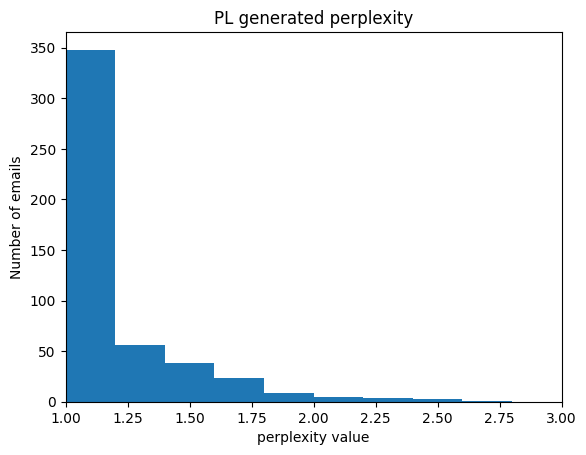

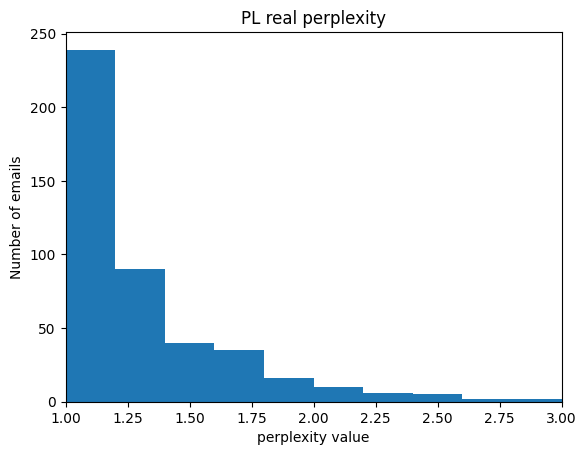

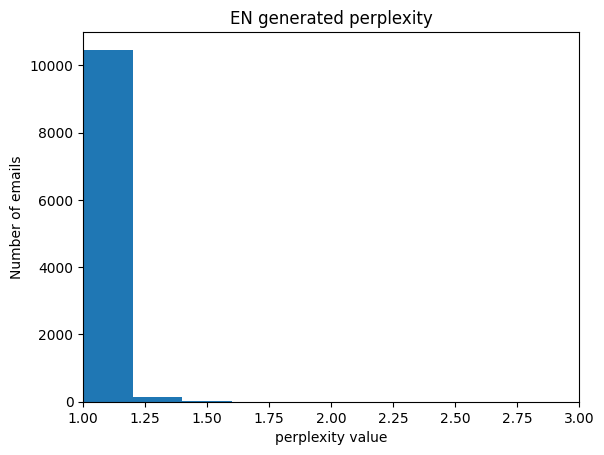

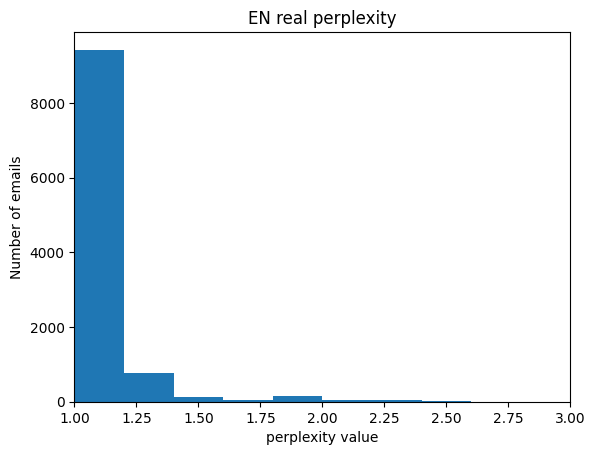

In [34]:
compare_4_hists('perplexity', min_value=1, max_value=3)

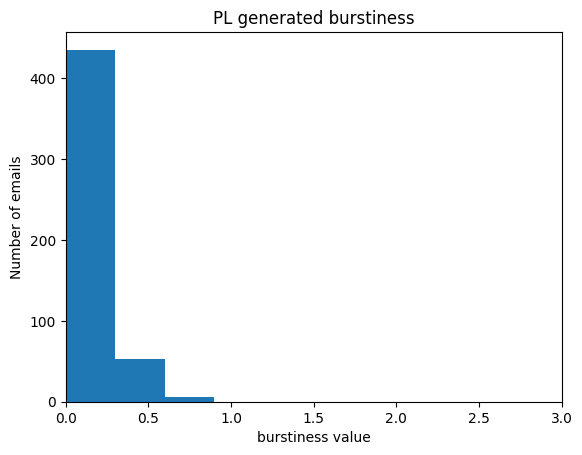

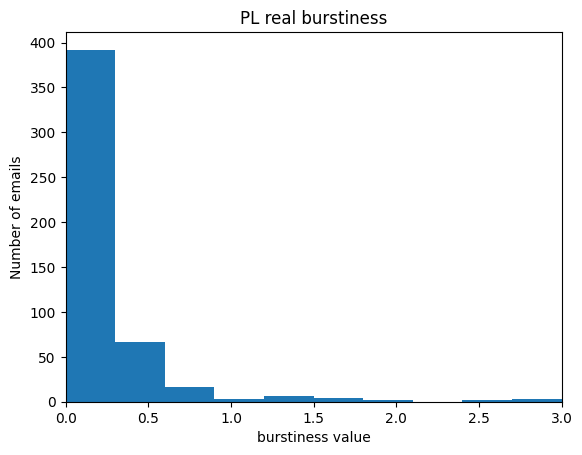

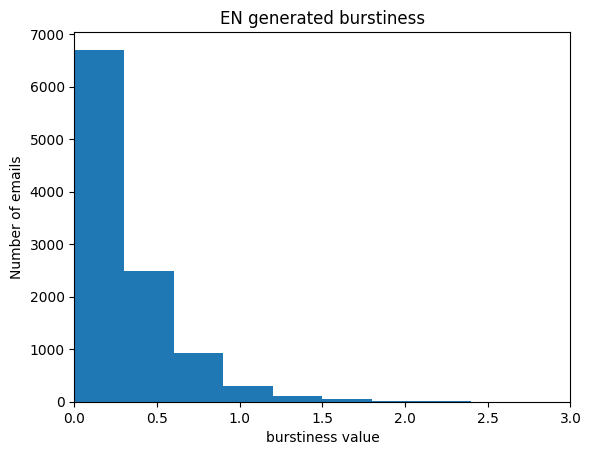

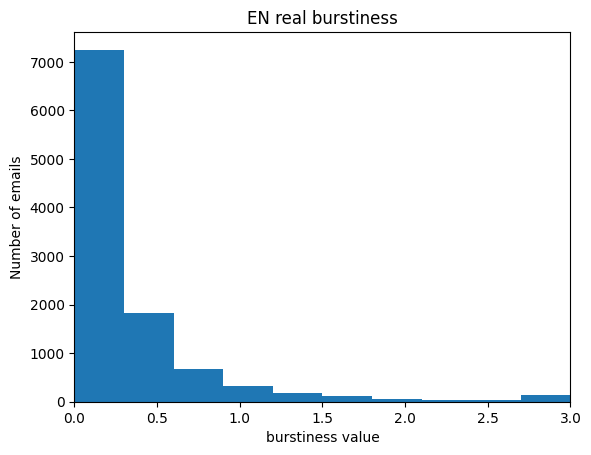

In [35]:
compare_4_hists('burstiness', min_value=0, max_value=3)

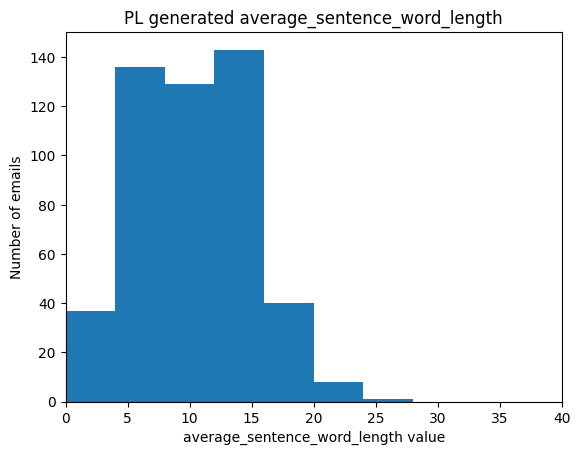

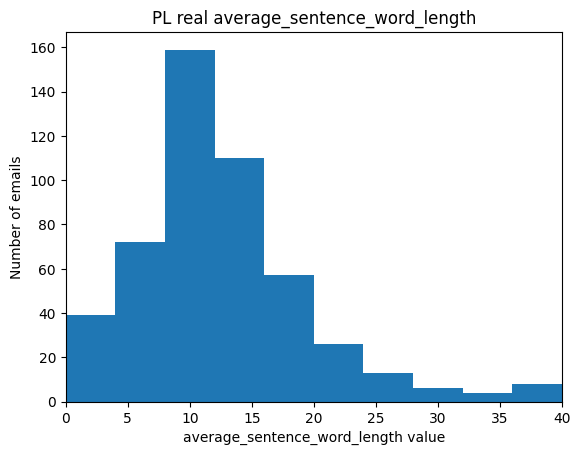

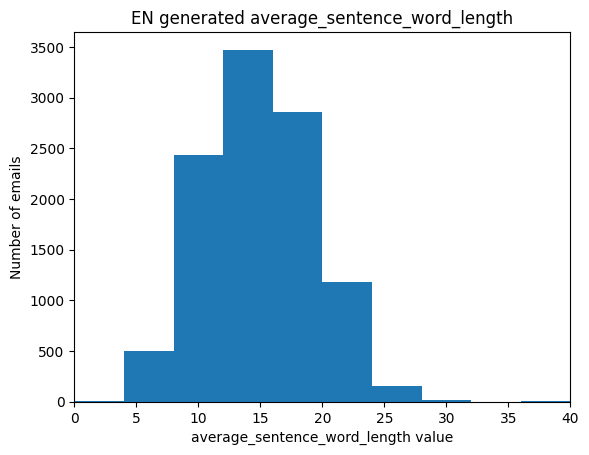

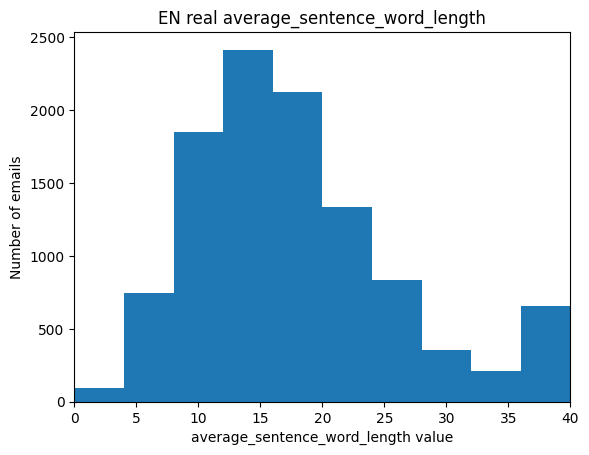

In [14]:
compare_4_hists('average_sentence_word_length', min_value=0, max_value=40)

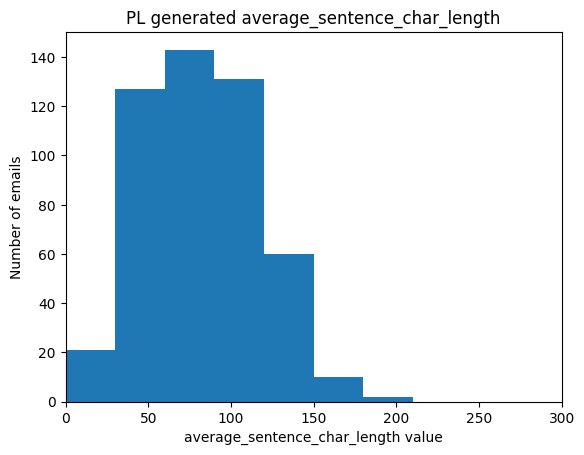

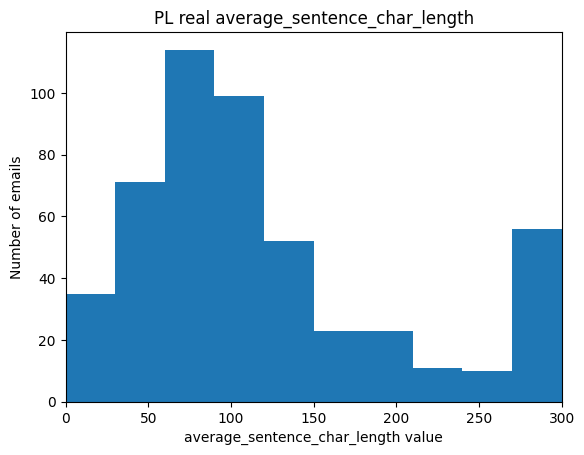

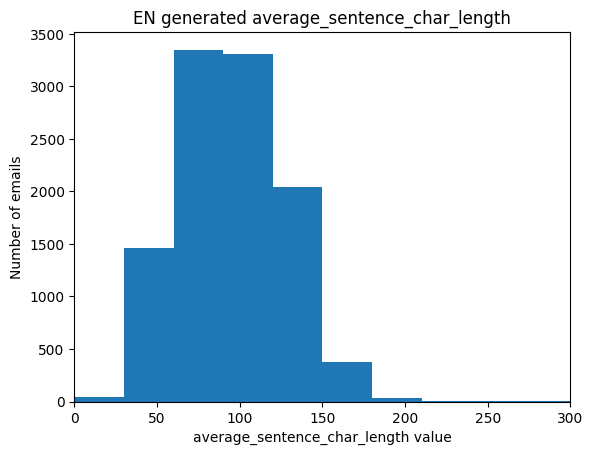

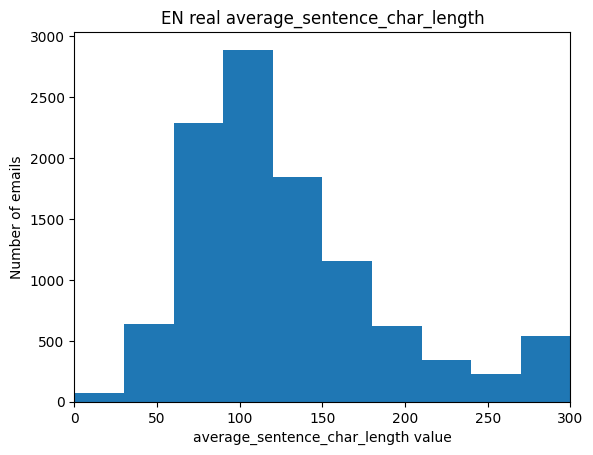

In [15]:
compare_4_hists('average_sentence_char_length', min_value=0, max_value=300)

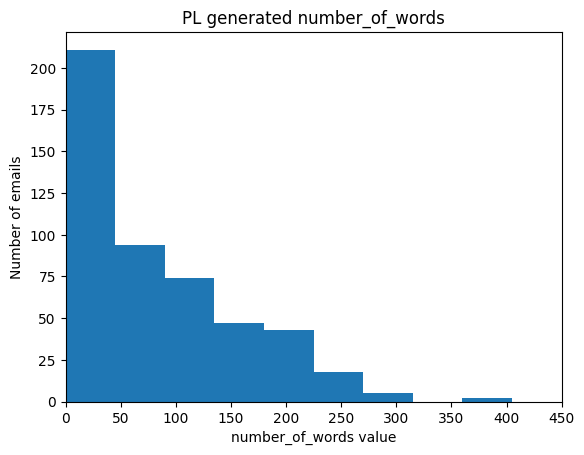

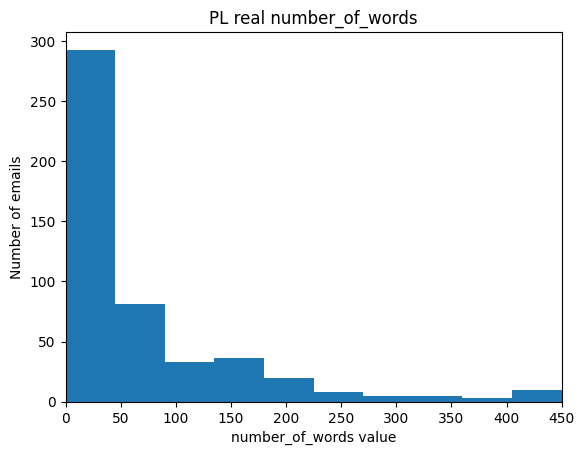

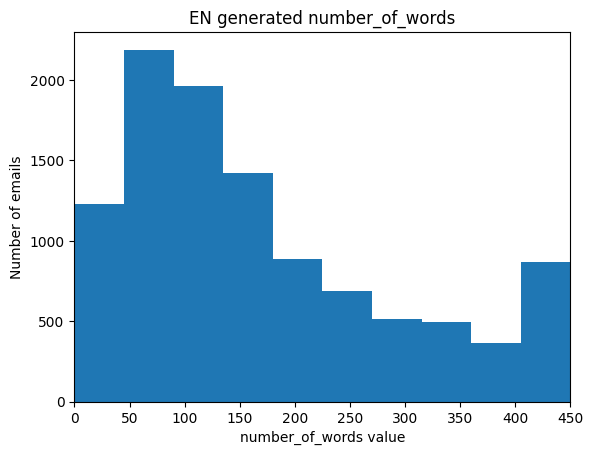

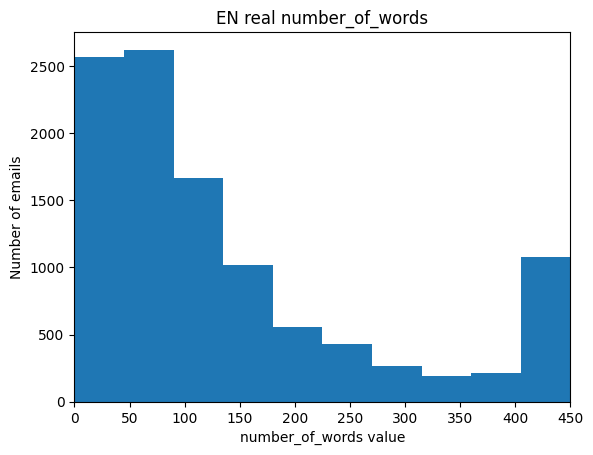

In [16]:
compare_4_hists('number_of_words', min_value=0, max_value=450)

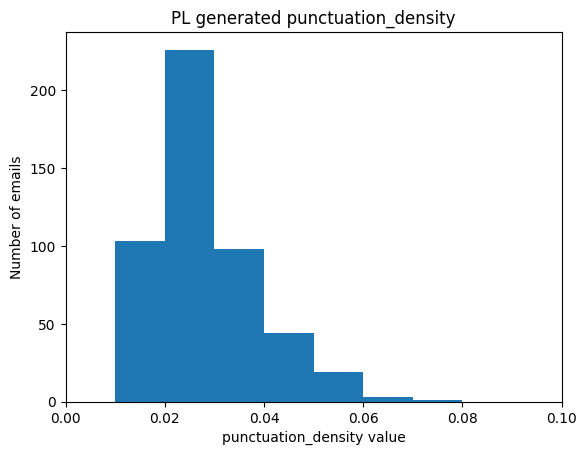

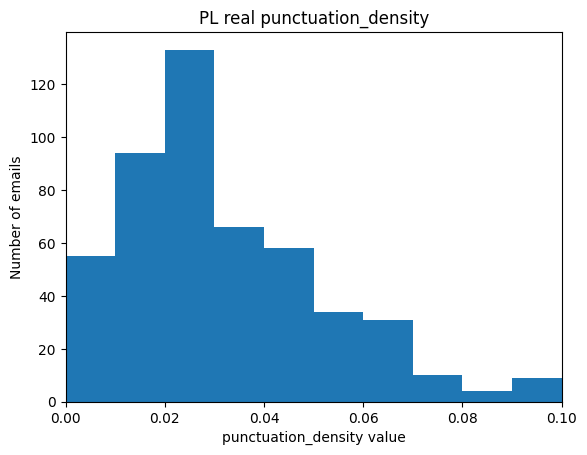

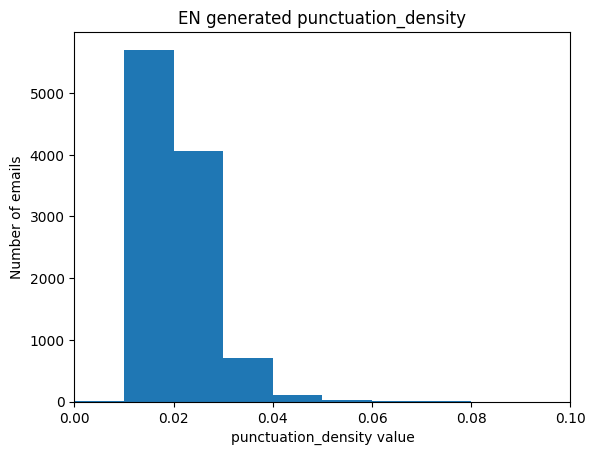

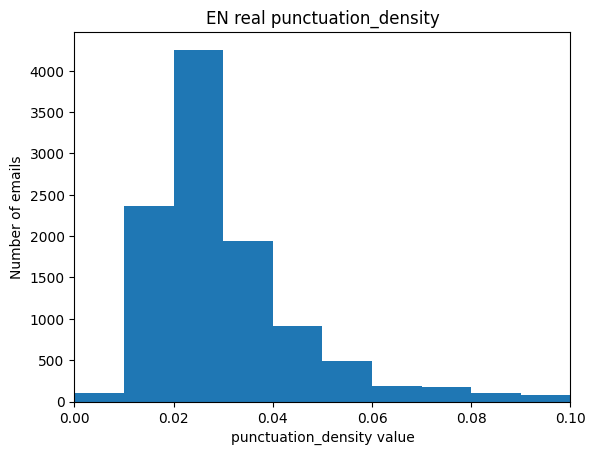

In [25]:
compare_4_hists('punctuation_density', min_value=0, max_value=0.1)

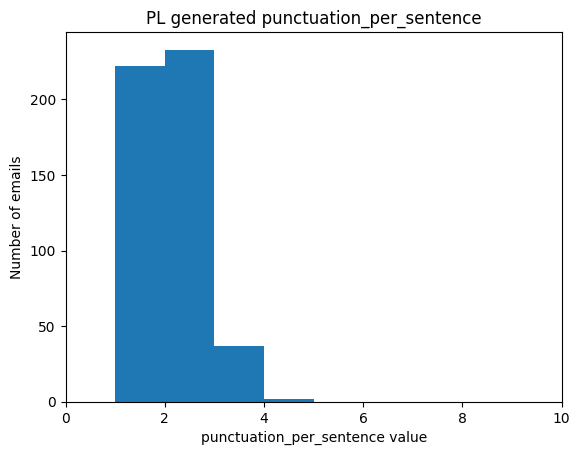

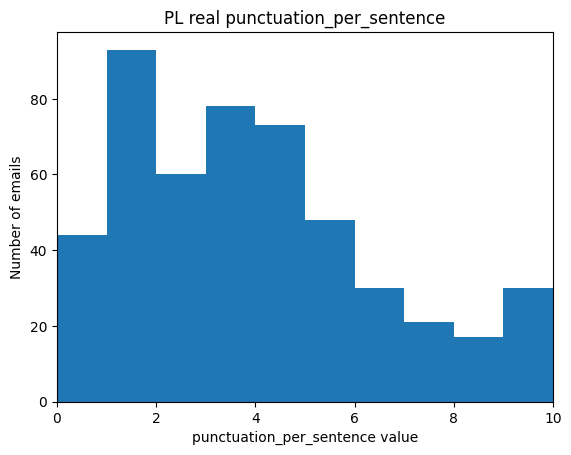

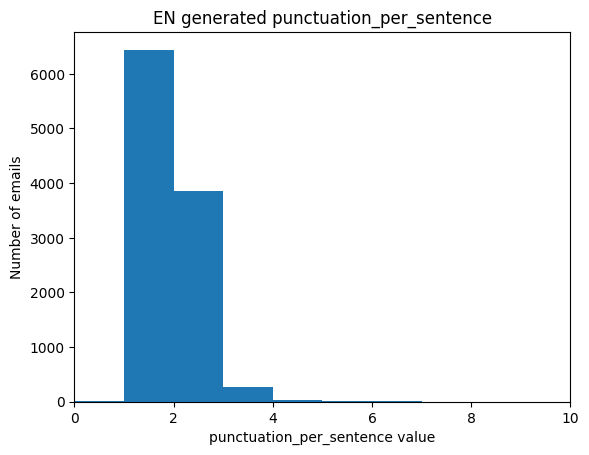

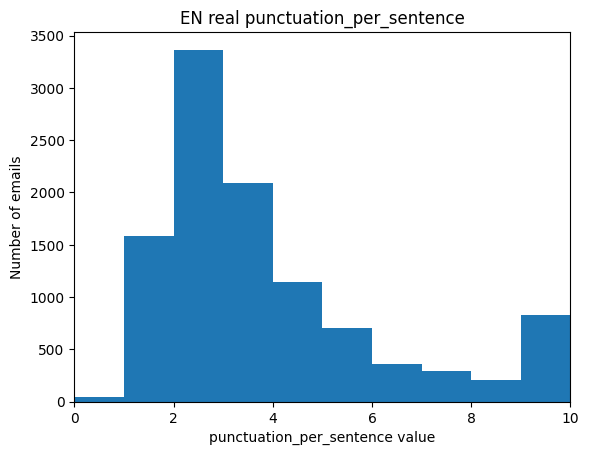

In [28]:
compare_4_hists('punctuation_per_sentence', min_value=0, max_value=10)

In [6]:
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import pandas as pd

def find_significant_features(data):
    """
    Identifies the most significant features in a list of data.
    
    Args:
    data (list of tuples): A list where each element is a tuple containing a dictionary of features and a label.
    num_features (int): The number of top features to select.

    Returns:
    list: Names of the top `num_features` significant features.
    """
    # Convert list of tuples into a DataFrame
    df = pd.DataFrame([item[0] for item in data])
    labels = [item[1] for item in data]

    # Fill missing values if necessary
    df.fillna(method='ffill', inplace=True)
    
    # Compute mutual information
    mi_scores = mutual_info_classif(df, labels)
    
    # Create a Series with feature names as the index and MI scores as the values
    mi_series = pd.Series(mi_scores, index=df.columns)

    # Sort the features by their mutual information scores in descending order
    sorted_features = mi_series.sort_values(ascending=False).index.tolist()
    
    return sorted_features

In [7]:
data = [[x.to_flat_dict(), 1]for x in pl_generated]
data += [[x.to_flat_dict(), 0] for x in pl_real]

In [7]:
data[0][0]

{'perplexity': 1.1858384711578742,
 'perplexity_base': 5.624853134155273,
 'burstiness': 0.0,
 'average_sentence_word_length': 10.333333333333334,
 'standard_deviation_sentence_word_length': 6.128258770283412,
 'variance_sentence_word_length': 37.55555555555556,
 'standard_deviation_sentence_char_length': 48.12714641678044,
 'variance_sentence_char_length': 2316.222222222222,
 'average_sentence_char_length': 81.33333333333333,
 'average_word_char_length': 6.454545454545454,
 'punctuation': 5,
 'punctuation_per_sentence': 1.6666666666666667,
 'punctuation_density': 0.020242914979757085,
 'number_of_sentences': 3,
 'number_of_words': 33,
 'number_of_characters': 247,
 'stylometrix_metrics.part_of_speech.POS_VERB': None,
 'stylometrix_metrics.part_of_speech.POS_NOUN': None,
 'stylometrix_metrics.part_of_speech.POS_ADJ': None,
 'stylometrix_metrics.part_of_speech.POS_ADV': None,
 'stylometrix_metrics.part_of_speech.POS_DET': None,
 'stylometrix_metrics.part_of_speech.POS_INTJ': None,
 'sty

In [9]:
# replace None with 0
for i in range(len(data)):
    for key in data[i][0].keys():
        if data[i][0][key] is None:
            data[i][0][key] = 0

In [10]:
significant_features = find_significant_features(data)

/tmp/ipykernel_1135/3016142918.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [11]:
significant_features

['standard_deviation_sentence_char_length',
 'variance_sentence_char_length',
 'number_of_errors',
 'no_space_after_punctuation',
 'text_errors_by_category.TYPOS',
 'standard_deviation_sentence_word_length',
 'variance_sentence_word_length',
 'punctuation_per_sentence',
 'double_spaces',
 'text_errors_by_category.TYPOGRAPHY',
 'average_sentence_char_length',
 'burstiness',
 'average_word_char_length',
 'number_of_characters',
 'punctuation',
 'question_marks',
 'average_sentence_word_length',
 'perplexity_base',
 'punctuation_density',
 'number_of_words',
 'text_errors_by_category.CASING',
 'text_errors_by_category.SPELLING',
 'perplexity',
 'text_errors_by_category.MISC',
 'number_of_sentences',
 'text_errors_by_category.NUMBERS',
 'text_errors_by_category.SYNTAX',
 'text_errors_by_category.PRAWDOPODOBNE_LITEROWKI',
 'emojis',
 'text_errors_by_category.PUNCTUATION',
 'stylometrix_metrics.syntactic.SY_INVERSE_PATTERNS',
 'stylometrix_metrics.verb_tenses.VT_SHOULD_PROGRESSIVE',
 'text_e

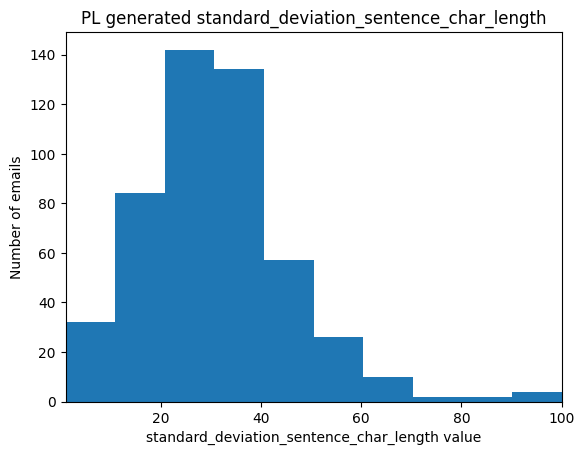

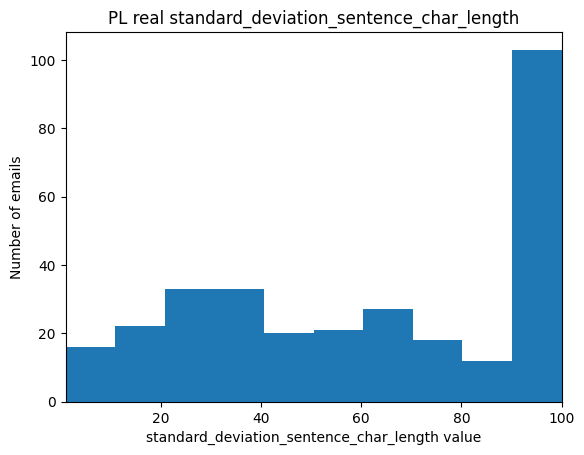

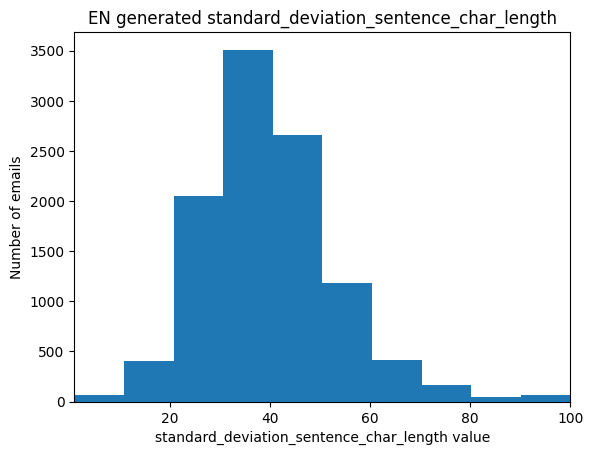

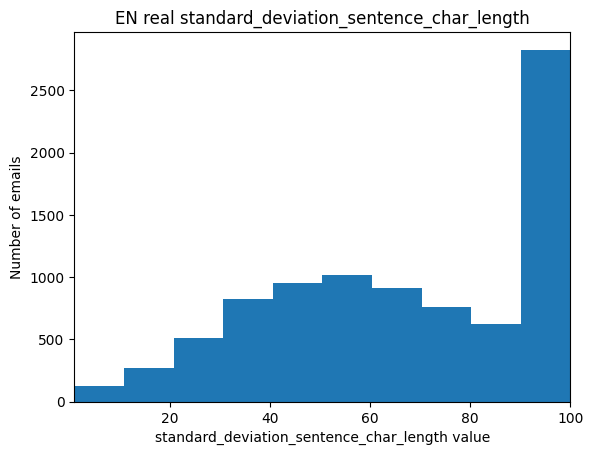

In [13]:
compare_4_hists('standard_deviation_sentence_char_length', min_value=1, max_value=100)

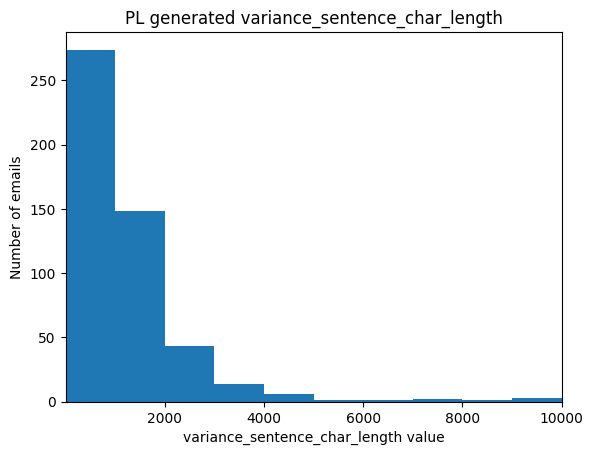

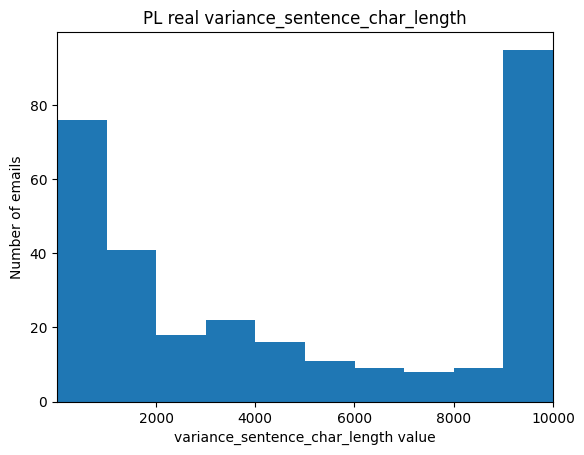

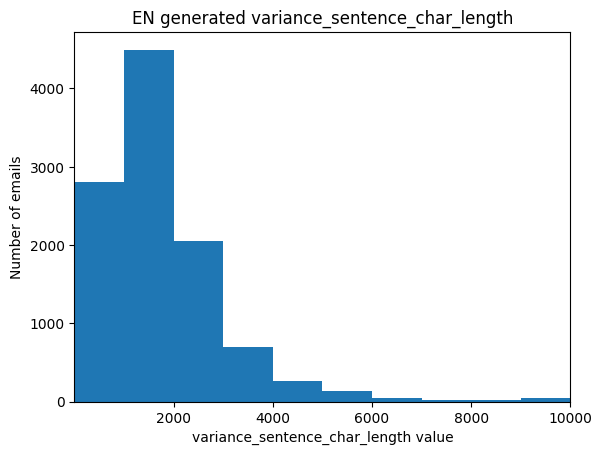

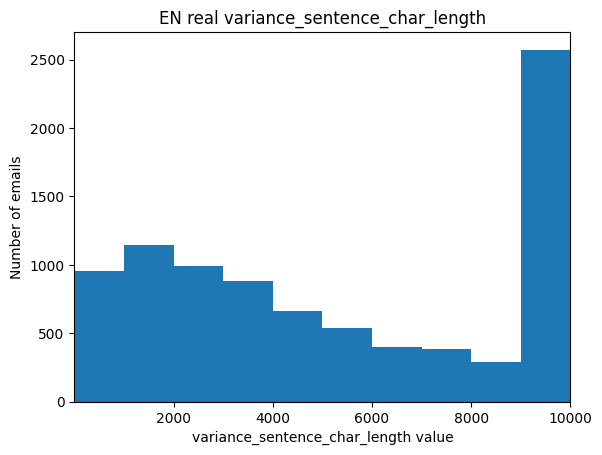

In [16]:
compare_4_hists('variance_sentence_char_length', min_value=1, max_value=10000)

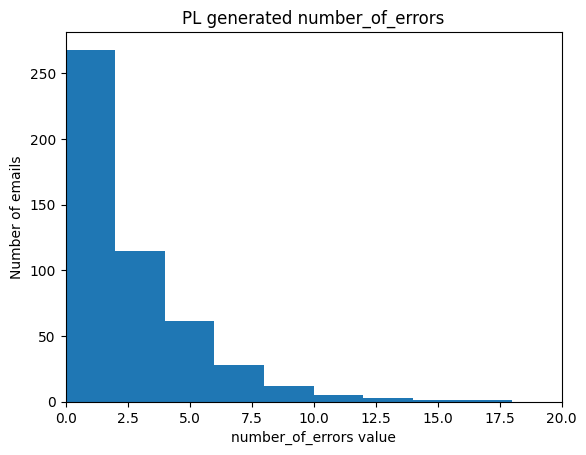

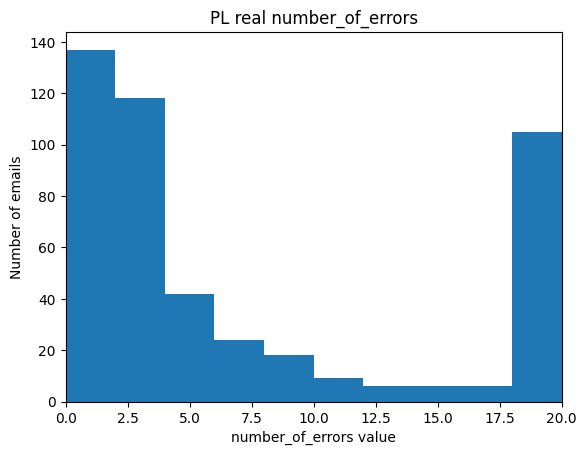

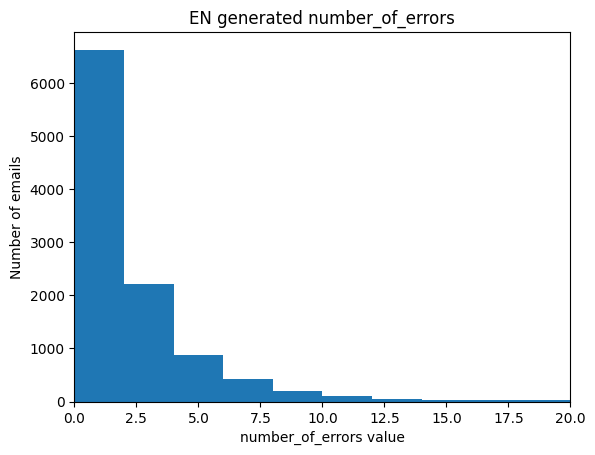

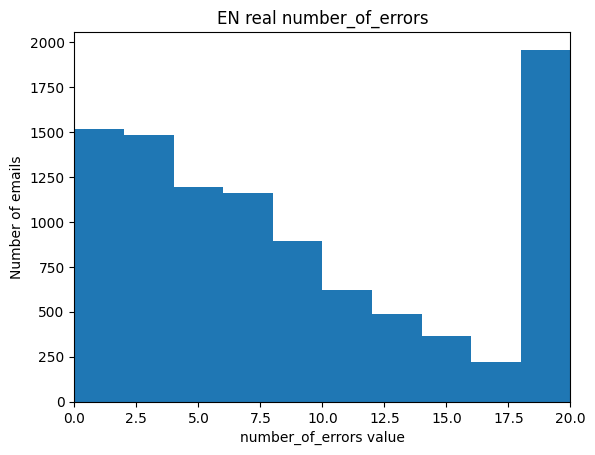

In [18]:
compare_4_hists('number_of_errors', min_value=0, max_value=20)

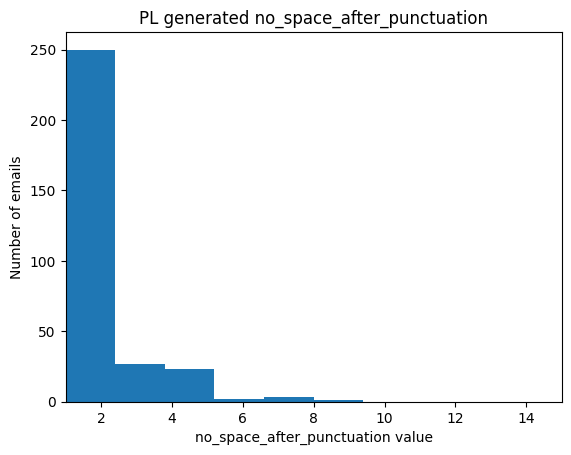

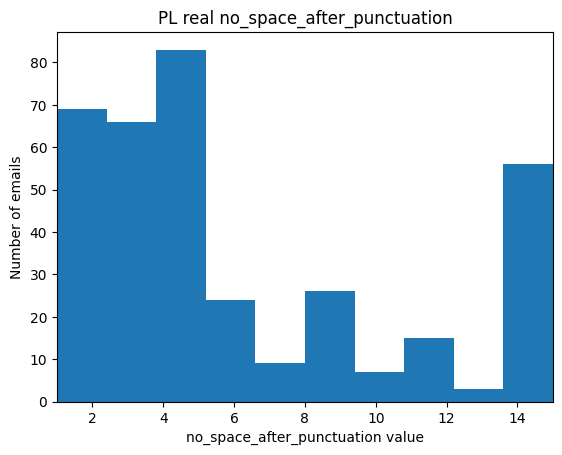

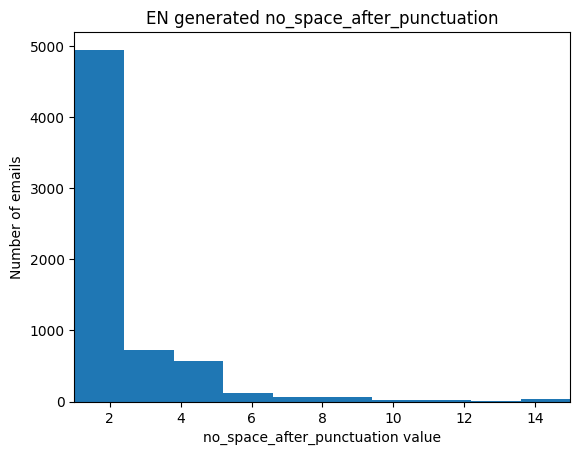

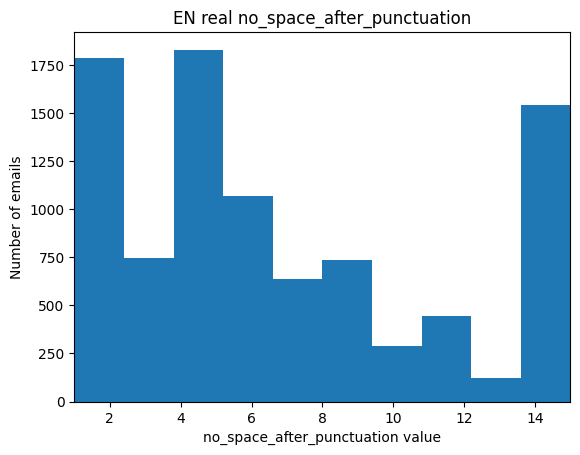

In [20]:
compare_4_hists('no_space_after_punctuation', min_value=1, max_value=15)

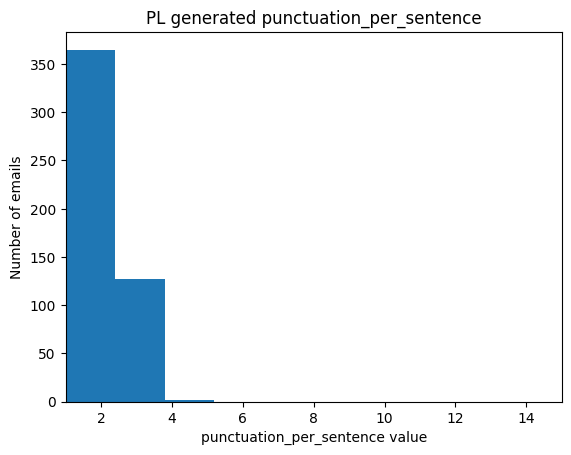

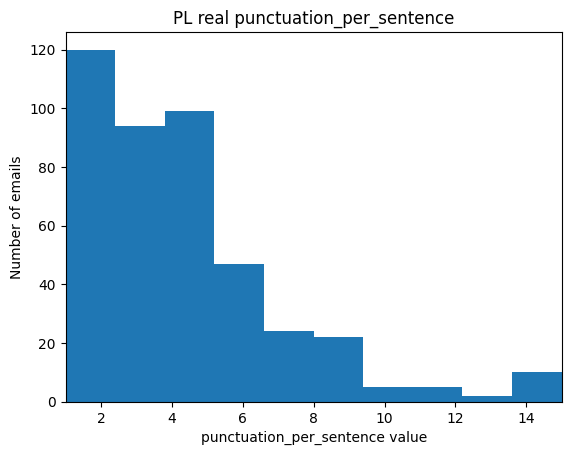

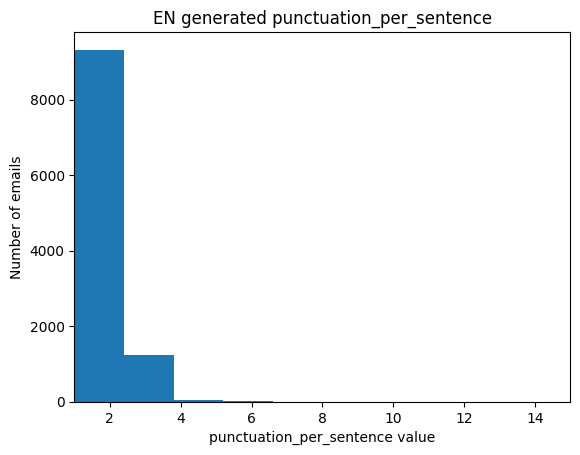

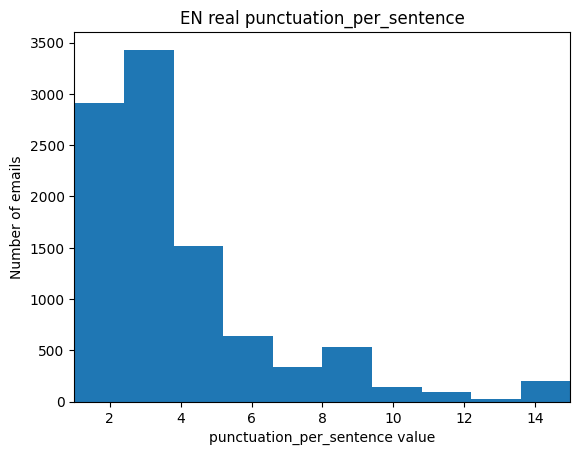

In [22]:
compare_4_hists('punctuation_per_sentence', min_value=1, max_value=15)